In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim 

from PIL import Image, ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True

import albumentations as A 
from albumentations.pytorch import ToTensorV2 
import cv2 

import os 
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import matplotlib.patches as patches 

from tqdm import tqdm
import gc


C:\Users\robot\AppData\Local\Temp\ipykernel_66852\3932783059.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Utility Functions

In [2]:
def iou(box1, box2, is_pred=True): 
    if is_pred: 
        # IoU score for prediction and label 
        # box1 (prediction) and box2 (label) are both in [x, y, width, height] format 
          
        # Box coordinates of prediction 
        b1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
        b1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
        b1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
        b1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2
  
        # Box coordinates of ground truth 
        b2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
        b2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
        b2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
        b2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2
  
        # Get the coordinates of the intersection rectangle 
        x1 = torch.max(b1_x1, b2_x1) 
        y1 = torch.max(b1_y1, b2_y1) 
        x2 = torch.min(b1_x2, b2_x2) 
        y2 = torch.min(b1_y2, b2_y2) 
        # Make sure the intersection is at least 0 
        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0) 
  
        # Calculate the union area 
        box1_area = abs((b1_x2 - b1_x1) * (b1_y2 - b1_y1)) 
        box2_area = abs((b2_x2 - b2_x1) * (b2_y2 - b2_y1)) 
        union = box1_area + box2_area - intersection 
  
        # Calculate the IoU score 
        epsilon = 1e-6
        iou_score = intersection / (union + epsilon) 
  
        # Return IoU score 
        return iou_score 
      
    else: 
        # IoU score based on width and height of bounding boxes 
          
        # Calculate intersection area 
        intersection_area = torch.min(box1[..., 0], box2[..., 0]) * torch.min(box1[..., 1], box2[..., 1]) 
  
        # Calculate union area 
        box1_area = box1[..., 0] * box1[..., 1] 
        box2_area = box2[..., 0] * box2[..., 1] 
        union_area = box1_area + box2_area - intersection_area 
  
        # Calculate IoU score 
        iou_score = intersection_area / union_area 
  
        # Return IoU score 
        return iou_score

In [3]:
def nms(bboxes, iou_threshold, threshold): 
    # Filter out bounding boxes with confidence below the threshold. 
    bboxes = [box for box in bboxes if box[1] > threshold] 
  
    # Sort the bounding boxes by confidence in descending order. 
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True) 
  
    # Initialize the list of bounding boxes after non-maximum suppression. 
    bboxes_nms = [] 
  
    while bboxes: 
        # Get the first bounding box. 
        first_box = bboxes.pop(0) 
  
        # Iterate over the remaining bounding boxes. 
        for box in bboxes: 
        # If the bounding boxes do not overlap or if the first bounding box has 
        # a higher confidence, then add the second bounding box to the list of 
        # bounding boxes after non-maximum suppression. 
            if box[0] != first_box[0] or iou( 
                torch.tensor(first_box[2:]), 
                torch.tensor(box[2:]), 
            ) < iou_threshold: 
                # Check if box is not in bboxes_nms 
                if box not in bboxes_nms: 
                    # Add box to bboxes_nms 
                    bboxes_nms.append(box) 
  
    # Return bounding boxes after non-maximum suppression. 
    return bboxes_nms

In [4]:
def convert_cells_to_bboxes(predictions, anchors, s, is_predictions=True): 
    # Batch size used on predictions 
    batch_size = predictions.shape[0] 
    # Number of anchors 
    num_anchors = len(anchors) 
    # List of all the predictions 
    box_predictions = predictions[..., 1:5] 
  
    # If the input is predictions then we will pass the x and y coordinate 
    # through sigmoid function and width and height to exponent function and 
    # calculate the score and best class. 
    if is_predictions: 
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2) 
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2]) 
        box_predictions[..., 2:] = torch.exp( 
            box_predictions[..., 2:]) * anchors 
        scores = torch.sigmoid(predictions[..., 0:1]) 
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1) 
      
    # Else we will just calculate scores and best class. 
    else: 
        scores = predictions[..., 0:1] 
        best_class = predictions[..., 5:6] 
  
    # Calculate cell indices 
    cell_indices = ( 
        torch.arange(s) 
        .repeat(predictions.shape[0], 3, s, 1) 
        .unsqueeze(-1) 
        .to(predictions.device) 
    ) 
  
    # Calculate x, y, width and height with proper scaling 
    x = 1 / s * (box_predictions[..., 0:1] + cell_indices) 
    y = 1 / s * (box_predictions[..., 1:2] +
                 cell_indices.permute(0, 1, 3, 2, 4)) 
    width_height = 1 / s * box_predictions[..., 2:4] 
  
    # Concatinating the values and reshaping them in 
    # (BATCH_SIZE, num_anchors * S * S, 6) shape 
    converted_bboxes = torch.cat( 
        (best_class, scores, x, y, width_height), dim=-1
    ).reshape(batch_size, num_anchors * s * s, 6) 
  
    # Returning the reshaped and converted bounding box list 
    return converted_bboxes.tolist()

In [5]:
def plot_image(image, boxes, class_labels): 
    # Getting the color map from matplotlib 
    colour_map = plt.get_cmap("tab20b")
    # Getting different colors from the color map for 20 different classes 
    colors = [colour_map(i) for i in np.linspace(0, 1, len(class_labels))] 
  
    # Reading the image with OpenCV 
    img = np.array(image) 
    # Getting the height and width of the image 
    h, w, _ = img.shape 
  
    # Create figure and axes 
    fig, ax = plt.subplots(1) 
  
    # Add image to plot 
    ax.imshow(img) 
  
    # Plotting the bounding boxes and labels over the image 
    for box in boxes: 
        # Get the class from the box 
        class_pred = box[0]
        # Get the center x and y coordinates 
        box = box[2:] 
        # Get the upper left corner coordinates 
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
  
        # Create a Rectangle patch with the bounding box 
        rect = patches.Rectangle( 
            (upper_left_x * w, upper_left_y * h), 
            box[2] * w, 
            box[3] * h, 
            linewidth=2, 
            edgecolor=colors[int(class_pred)], 
            facecolor="none", 
        ) 
          
        # Add the patch to the Axes 
        ax.add_patch(rect) 
          
        # Add class name to the patch 
        plt.text( 
            upper_left_x * w, 
            upper_left_y * h, 
            s=class_labels[int(class_pred)], 
            color="white", 
            verticalalignment="top", 
            bbox={"color": colors[int(class_pred)], "pad": 0}, 
        ) 
  
    # Convert the plot to a numpy array
    fig.canvas.draw()
    img_array = np.array(fig.canvas.renderer.buffer_rgba())

    # Close the plot to free up memory
    plt.close(fig)

    return img_array

In [6]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"): 
    print("==> Saving checkpoint") 
    checkpoint = { 
        "state_dict": model.state_dict(), 
        "optimizer": optimizer.state_dict(), 
    } 
    torch.save(checkpoint, filename)

In [7]:
def load_checkpoint(checkpoint_file, model, optimizer, lr): 
    print("==> Loading checkpoint") 
    checkpoint = torch.load(checkpoint_file, map_location=device) 
    model.load_state_dict(checkpoint["state_dict"]) 
    optimizer.load_state_dict(checkpoint["optimizer"]) 
  
    for param_group in optimizer.param_groups: 
        param_group["lr"] = lr 

In [8]:
# Device 
device = "cuda" if torch.cuda.is_available() else "cpu"
  
# Load and save model variable 
load_model = False
save_model = True
  
# model checkpoint file name 
checkpoint_file = "checkpoint.pth.tar"
  
# Anchor boxes for each feature map scaled between 0 and 1 
# 3 feature maps at 3 different scales based on YOLOv3 paper 
ANCHORS = [ 
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)], 
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)], 
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)], 
] 
  
# Batch size for training 
batch_size = 32
  
# Learning rate for training 
leanring_rate = 1e-5
  
# Number of epochs for training 
epochs = 50
  
# Image size 
image_size = 416
  
# Grid cell sizes 
s = [image_size // 32, image_size // 16, image_size // 8] 
  
# Class labels 
# class_labels = [ 
#     "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", 
#     "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", 
#     "pottedplant", "sheep", "sofa", "train", "tvmonitor","face"
# ]
class_labels = [ 
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", 
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "face",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor","License_Plate", "motorcyle", "truck"
]

In [9]:
import os
import shutil
from PIL import Image
from torchvision import transforms

def preprocess_new_data(old_directory, new_directory):
    # Define your transformations
    preprocess = transforms.Compose([
        transforms.Resize((416, 416)),
        transforms.ToTensor()  # Convert the image to a tensor
    ])

    augment = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(416, scale=(0.75, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomGrayscale(p=0.05),
        transforms.ColorJitter(hue=0.2, saturation=0.1, brightness=0.22),
        transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.05),
        transforms.RandomErasing(p=0.05, scale=(0.02, 0.02), ratio=(1, 1)),
        transforms.ToPILImage()  # Convert the tensor back to an image
    ])

    os.makedirs(new_directory, exist_ok=True)

    # Apply the transformations and save the images
    for file_name in os.listdir(old_directory):
        old_path = os.path.join(old_directory, file_name)
        new_path = os.path.join(new_directory, file_name)

        if file_name.endswith('.jpg'):
            image = Image.open(old_path)
            image = augment(preprocess(image))
            image.save(new_path)
        else:
            shutil.copy(old_path, new_path)

In [ ]:
preprocess_new_data('/kaggle/input/new-face-data/train','new-face-data/train')

In [ ]:
# Prepare the additional dataset (face detection)
import os
import csv

# Directories
image_directory = '/kaggle/input/dataset'
labels_directory = '/kaggle/input/face-detection-annotations/obj_train_data'

# Prepare lists to hold file paths
images = []
labels = []

# List all files in the image directory and filter out non-JPG files
for file in os.listdir(image_directory):
    if file.endswith('.jpg'):
        images.append(file)

# For each image, find the corresponding label file
for image_file in images:
    # Construct the corresponding label file name
    label_file = image_file.replace('.jpg', '.txt')
    
    # Check if the label file exists in the labels directory
    if os.path.exists(os.path.join(labels_directory, label_file)):
        labels.append(label_file)
    else:
        # Handle the case where the label file does not exist
        print(f"Label file for {image_file} not found.")
        labels.append(None)  # Or handle it in some other way

# Now, you have two lists: 'images' and 'labels' with matched files
# Write them to a CSV file
csv_file_path = '/kaggle/working/face_detection_train_dataset.csv'
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image', 'label'])  # Header
    for image, label in zip(images, labels):
        if label is not None:  # Only write rows for which the label file exists
            writer.writerow([os.path.join(image_directory, image), os.path.join(labels_directory, label)])

print(f"CSV file created at {csv_file_path}")


In [10]:
import os
import shutil
import pandas as pd

def remove_class_and_save_new_dataset(csv_path, img_dir, label_dir, class_to_remove, new_dataset_dir):
    df = pd.read_csv(csv_path, names=['image', 'label'], skiprows=1)  # Assuming the first row is header
    filtered_image_names = []
    filtered_label_names = []

    new_img_dir = os.path.join(new_dataset_dir, 'images')
    new_label_dir = os.path.join(new_dataset_dir, 'labels')

    os.makedirs(new_img_dir, exist_ok=True)
    os.makedirs(new_label_dir, exist_ok=True)

    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['image'])
        label_path = os.path.join(label_dir, row['label'])

        with open(label_path, 'r') as f:
            labels = f.readlines()

        filtered_labels = [label for label in labels if int(label.split()[0]) != class_to_remove]

        if filtered_labels:
            new_img_name = os.path.basename(img_path)
            new_label_name = os.path.basename(label_path)

            new_img_path = os.path.join(new_img_dir, new_img_name)
            new_label_path = os.path.join(new_label_dir, new_label_name)

            shutil.copyfile(img_path, new_img_path)
            shutil.copyfile(label_path, new_label_path)

            with open(new_label_path, 'w') as f:
                f.writelines(filtered_labels)

            filtered_image_names.append(new_img_name)  # Store only the file name
            filtered_label_names.append(new_label_name)  # Store only the file name

    new_df = pd.DataFrame({
        'image': filtered_image_names,
        'label': filtered_label_names
    })
    new_csv_path = os.path.join(new_dataset_dir, 'filtered_dataset.csv')
    new_df.to_csv(new_csv_path, index=False)
    print(f"Filtered dataset CSV saved to {new_csv_path}")

remove_class_and_save_new_dataset('/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv', '/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images', '/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels', 14, '/kaggle/working/modified')


In [11]:
def append_and_replace_class(old_csv_path, old_img_dir, old_label_dir, class_to_replace, new_class_label, new_dataset_dir):
    old_df = pd.read_csv(old_csv_path)
    new_image_names = []  # Changed from new_image_paths
    new_label_names = []  # Changed from new_label_paths

    new_img_dir = os.path.join(new_dataset_dir, 'images')
    new_label_dir = os.path.join(new_dataset_dir, 'labels')

    for _, row in old_df.iterrows():
        img_path = os.path.join(old_img_dir, row['image'])
        label_path = os.path.join(old_label_dir, row['label'])

        with open(label_path, 'r') as f:
            labels = f.readlines()

        replaced_labels = [str(new_class_label) + label[1:] if int(label.split()[0]) == class_to_replace else label for label in labels]

        new_img_name = os.path.basename(img_path)  # Changed from new_img_path
        new_label_name = os.path.basename(label_path)  # Changed from new_label_path

        new_img_path = os.path.join(new_img_dir, new_img_name)
        new_label_path = os.path.join(new_label_dir, new_label_name)

        shutil.copyfile(img_path, new_img_path)

        with open(new_label_path, 'w') as f:
            f.writelines(replaced_labels)

        new_image_names.append(new_img_name)  # Changed from new_img_path
        new_label_names.append(new_label_name)  # Changed from new_label_path

    new_df = pd.DataFrame({
        'image': new_image_names,  # Changed from new_image_paths
        'label': new_label_names  # Changed from new_label_paths
    })

    new_df.to_csv(os.path.join(new_dataset_dir, 'filtered_dataset.csv'), mode='a', header=False, index=False)

append_and_replace_class('/kaggle/working/face_detection_train_dataset.csv', '/kaggle/input/dataset', '/kaggle/input/face-detection-annotations/obj_train_data', 0, 14, '/kaggle/working/modified')

In [ ]:
def append_and_replace_class(old_csv_path, old_img_dir, old_label_dir, class_to_replace, new_class_label, new_dataset_dir):
    old_df = pd.read_csv(old_csv_path)
    new_image_names = []  # Changed from new_image_paths
    new_label_names = []  # Changed from new_label_paths

    new_img_dir = os.path.join(new_dataset_dir, 'images')
    new_label_dir = os.path.join(new_dataset_dir, 'labels')

    for _, row in old_df.iterrows():
        img_path = os.path.join(old_img_dir, row['image'])
        label_path = os.path.join(old_label_dir, row['label'])

        with open(label_path, 'r') as f:
            labels = f.readlines()

        replaced_labels = [str(new_class_label) + label[1:] if int(label.split()[0]) == class_to_replace else label for label in labels]

        new_img_name = os.path.basename(img_path)  # Changed from new_img_path
        new_label_name = os.path.basename(label_path)  # Changed from new_label_path

        new_img_path = os.path.join(new_img_dir, new_img_name)
        new_label_path = os.path.join(new_label_dir, new_label_name)

        shutil.copyfile(img_path, new_img_path)

        with open(new_label_path, 'w') as f:
            f.writelines(replaced_labels)

        new_image_names.append(new_img_name)  # Changed from new_img_path
        new_label_names.append(new_label_name)  # Changed from new_label_path

    new_df = pd.DataFrame({
        'image': new_image_names,  # Changed from new_image_paths
        'label': new_label_names  # Changed from new_label_paths
    })

    new_df.to_csv(os.path.join(new_dataset_dir, 'filtered_dataset.csv'), mode='a', header=False, index=False)

append_and_replace_class('/kaggle/working/face_detection_train_dataset.csv', '/kaggle/input/dataset', '/kaggle/input/face-detection-annotations/obj_train_data', 0, 14, '/kaggle/working/modified')

In [ ]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

def update_dataset_and_csv(old_root_dir, new_root_dir, csv_file_name, old_class, new_class):
    subsets = ['train', 'validation']
    new_images_dir = os.path.join(new_root_dir, 'images')
    new_labels_dir = os.path.join(new_root_dir, 'labels')
    os.makedirs(new_images_dir, exist_ok=True)
    os.makedirs(new_labels_dir, exist_ok=True)

    csv_path = os.path.join(new_root_dir, csv_file_name)
    if os.path.exists(csv_path):
        existing_df = pd.read_csv(csv_path)
    else:
        existing_df = pd.DataFrame(columns=['image', 'label'])

    new_entries = []

    for subset in subsets:
        old_images_dir = os.path.join(old_root_dir, 'images', subset)
        old_labels_dir = os.path.join(old_root_dir, 'labels', subset)

        image_files = [f for f in os.listdir(old_images_dir) if f.endswith('.jpg')]
        label_files = [f.replace('.jpg', '.txt') for f in image_files]

        for image_file, label_file in tqdm(zip(image_files, label_files), total=len(image_files), desc=f"Processing {subset}"):
            if not existing_df['image'].str.contains(image_file).any():
                # Copy image
                old_image_path = os.path.join(old_images_dir, image_file)
                new_image_path = os.path.join(new_images_dir, image_file)
                shutil.copyfile(old_image_path, new_image_path)

                # Copy and possibly modify label file
                old_label_path = os.path.join(old_labels_dir, label_file)
                new_label_path = os.path.join(new_labels_dir, label_file)
                if os.path.exists(old_label_path):
                    with open(old_label_path, 'r') as file:
                        labels = file.readlines()
                    labels = [str(new_class) + label[1:] if int(label.split()[0]) == old_class else label for label in labels]
                    with open(new_label_path, 'w') as file:
                        file.writelines(labels)
                else:
                    print(f"Warning: Label file {label_file} does not exist for {image_file}.")

                # Add new entry for the CSV update
                new_entries.append({'image': image_file, 'label': label_file})

    # Create DataFrame from new entries and concatenate with the existing DataFrame
    if new_entries:
        new_entries_df = pd.DataFrame(new_entries)
        updated_df = pd.concat([existing_df, new_entries_df], ignore_index=True)
        updated_df.to_csv(csv_path, index=False)
        print(f"Dataset and CSV file updated successfully. CSV path: {csv_path}")
    else:
        print("No new entries to add to the CSV.")

# Define your parameters
old_root_dir = '/kaggle/input/face-detection-dataset/merged'  # Update this to your source dataset path
new_root_dir = '/kaggle/working/modified'  # Update this to your destination path
csv_file_name = '/kaggle/working/modified/filtered_dataset.csv'  # The CSV file to be updated or created
old_class = 0  # Original class ID to replace
new_class = 14  # New class ID

update_dataset_and_csv(old_root_dir, new_root_dir, csv_file_name, old_class, new_class)


In [9]:
def clamp_bbox_coords(bboxes, epsilon=1e-7):
    for bbox in bboxes:
        #print(bbox)
        if bbox[0]<0:
            print(f"Error at the box: {bbox[0]}")
        if bbox[1]<0:
            print(f"Error at the box: {bbox[1]}")
        if bbox[2]<0:
            print(f"Error at the box: {bbox[2]}")
        if bbox[3]<0:
            print(f"Error at the box: {bbox[3]}")
        bbox[0] = max(0.0 + epsilon, min(1.0 - epsilon, bbox[0]))  # x_center
        bbox[1] = max(0.0 + epsilon, min(1.0 - epsilon, bbox[1]))  # y_center
        bbox[2] = max(0.0, min(1.0 - 2*epsilon, bbox[2]))  # width
        bbox[3] = max(0.0, min(1.0 - 2*epsilon, bbox[3]))  # height
    return bboxes


In [9]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset as TorchConcatDataset
import pandas as pd
import os
from PIL import Image
import numpy as np
import csv
import torch
import logging


# Create a dataset class to load the images and labels from the folder 
class ObjectDetectionDataset(torch.utils.data.Dataset): 
    def __init__( 
        self, csv_file, image_dir, label_dir, anchors,  
        image_size=416, grid_sizes=[13, 26, 52], 
        num_classes=23, transform=None
    ): 
        # Read the csv file with image names and labels 
        self.label_list = pd.read_csv(csv_file) 
        # Image and label directories 
        self.image_dir = image_dir 
        self.label_dir = label_dir 
        # Image size 
        self.image_size = image_size 
        # Transformations 
        self.transform = transform 
        # Grid sizes for each scale 
        self.grid_sizes = grid_sizes 
        # Anchor boxes 
        self.anchors = torch.tensor( 
            anchors[0] + anchors[1] + anchors[2]) 
        # Number of anchor boxes  
        self.num_anchors = self.anchors.shape[0] 
        # Number of anchor boxes per scale 
        self.num_anchors_per_scale = self.num_anchors // 3
        # Number of classes 
        self.num_classes = num_classes 
        # Ignore IoU threshold 
        self.ignore_iou_thresh = 0.5
  
    def __len__(self): 
        return len(self.label_list) 
      
    def __getitem__(self, idx): 
        # Getting the label path 
        label_path = os.path.join(self.label_dir, self.label_list.iloc[idx, 1]) 
        # We are applying roll to move class label to the last column 
        # 5 columns: x, y, width, height, class_label 
        bboxes = np.roll(np.loadtxt(fname=label_path, 
                         delimiter=" ", ndmin=2), 4, axis=1).tolist() 
#         print(bboxes)
#         print("*************************************************************************")
        # Getting the image path 
        img_path = os.path.join(self.image_dir, self.label_list.iloc[idx, 0]) 
        image = np.array(Image.open(img_path).convert("RGB")) 
  
        # Albumentations augmentations 
        #bboxes = clamp_bbox_values(bboxes)
#         print(bboxes)
#         print(label_path)
        if self.transform:
            
            bboxes = clamp_bbox_coords(bboxes)
            augs = self.transform(image=image, bboxes=bboxes) 
            image = augs["image"] 
            bboxes = augs["bboxes"]
            
  
        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale 
        # target : [probabilities, x, y, width, height, class_label] 
        targets = [torch.zeros((self.num_anchors_per_scale, s, s, 6)) 
                   for s in self.grid_sizes] 
          
        # Identify anchor box and cell for each bounding box 
        for box in bboxes: 
            # Calculate iou of bounding box with anchor boxes 
            iou_anchors = iou(torch.tensor(box[2:4]),  
                              self.anchors,  
                              is_pred=False) 
            # Selecting the best anchor box 
            anchor_indices = iou_anchors.argsort(descending=True, dim=0) 
            x, y, width, height, class_label = box
           
  
            # At each scale, assigning the bounding box to the  
            # best matching anchor box 
            has_anchor = [False] * 3
            for anchor_idx in anchor_indices: 
                scale_idx = anchor_idx // self.num_anchors_per_scale 
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale 
                  
                # Identifying the grid size for the scale 
                s = self.grid_sizes[scale_idx] 
                  
                # Identifying the cell to which the bounding box belongs 
                i, j = int(s * y), int(s * x) 
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0] 
                  
                # Check if the anchor box is already assigned 
                if not anchor_taken and not has_anchor[scale_idx]: 
  
                    # Set the probability to 1 
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
  
                    # Calculating the center of the bounding box relative 
                    # to the cell 
                    x_cell, y_cell = s * x - j, s * y - i  
  
                    # Calculating the width and height of the bounding box  
                    # relative to the cell 
                    width_cell, height_cell = (width * s, height * s) 
  
                    # Idnetify the box coordinates 
                    box_coordinates = torch.tensor( 
                                        [x_cell, y_cell, width_cell,  
                                         height_cell] 
                                    ) 
  
                    # Assigning the box coordinates to the target 
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates 
  
                    # Assigning the class label to the target 
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label) 
  
                    # Set the anchor box as assigned for the scale 
                    has_anchor[scale_idx] = True
  
                # If the anchor box is already assigned, check if the  
                # IoU is greater than the threshold 
                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh: 
                    # Set the probability to -1 to ignore the anchor box 
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1
  
        # Return the image and the target 
        return image, tuple(targets)

In [14]:
# class ConcatDataset(Dataset):
#     def __init__(self, *datasets):
#         self.datasets = [dataset for dataset in datasets if dataset]
#         self.lengths = [len(dataset) for dataset in self.datasets]
#         print(self.lengths)
#         self.offsets = [0] + [sum(self.lengths[:i+1]) for i in range(len(self.lengths))]
#         self.total_length = sum(self.lengths)

#     def __getitem__(self, idx):
#         if idx < 0 or idx >= self.total_length:
#             raise IndexError(f"Index {idx} is out of bounds for ConcatDataset of length {self.total_length}")
#         for dataset, offset in zip(self.datasets, self.offsets):
#             if idx < offset:
#                 continue
#             try:
#                 item = dataset[idx - offset]
#                 if item is not None:
#                     return item
#             except IndexError:
#                 pass
#         raise IndexError(f"Index {idx} calculation error in ConcatDataset")

#     def __len__(self):
#         return self.total_length

In [10]:
# Transform for training 
train_transform = A.Compose( 
    [ 
        # Rescale an image so that maximum side is equal to image_size 
        A.LongestMaxSize(max_size=image_size), 
        # Pad remaining areas with zeros 
        A.PadIfNeeded( 
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT 
        ), 
        # Random color jittering 
        A.ColorJitter( 
            brightness=0.5, contrast=0.5, 
            saturation=0.5, hue=0.5, p=0.5
        ), 
        # Flip the image horizontally 
        A.HorizontalFlip(p=0.5), 
        # Normalize the image 
        A.Normalize( 
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ), 
        # Convert the image to PyTorch tensor 
        ToTensorV2() 
    ],  
    # Augmentation for bounding boxes 
    bbox_params=A.BboxParams( 
                    format="yolo",  
                    min_visibility=0.4,  
                    label_fields=[] 
                ) 
) 
  
# Transform for testing 
test_transform = A.Compose( 
    [ 
        # Rescale an image so that maximum side is equal to image_size 
        A.LongestMaxSize(max_size=image_size), 
        # Pad remaining areas with zeros 
        A.PadIfNeeded( 
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT 
        ), 
        # Normalize the image 
        A.Normalize( 
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ), 
        # Convert the image to PyTorch tensor 
        ToTensorV2() 
    ], 
    # Augmentation for bounding boxes  
    bbox_params=A.BboxParams( 
                    format="yolo",  
                    min_visibility=0.4,  
                    label_fields=[] 
                ) 
)

# Class that mimics the dataset loading and capture the images and labels which have wrong annotations

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import numpy as np
import logging
from tqdm import tqdm
# Setup logging
logging.basicConfig(filename='error_log.txt', level=logging.INFO, 
                    format='%(asctime)s:%(levelname)s:%(message)s')

class RobustObjectDetectionDataset(Dataset): 
    def __init__(self, csv_file, image_dir, label_dir, anchors, image_size=416, 
                 grid_sizes=[13, 26, 52], num_classes=20, transform=None): 
         # Read the csv file with image names and labels 
        self.label_list = pd.read_csv(csv_file) 
        # Image and label directories 
        self.image_dir = image_dir 
        self.label_dir = label_dir 
        # Image size 
        self.image_size = image_size 
        # Transformations 
        self.transform = transform 
        # Grid sizes for each scale 
        self.grid_sizes = grid_sizes 
        # Anchor boxes 
        self.anchors = torch.tensor( 
            anchors[0] + anchors[1] + anchors[2]) 
        # Number of anchor boxes  
        self.num_anchors = self.anchors.shape[0] 
        # Number of anchor boxes per scale 
        self.num_anchors_per_scale = self.num_anchors // 3
        # Number of classes 
        self.num_classes = num_classes 
        # Ignore IoU threshold 
        self.ignore_iou_thresh = 0.5
  
    def __len__(self): 
        return len(self.label_list) 

    def __getitem__(self, idx): 
        # Getting the label path 
        label_path = os.path.join(self.label_dir, self.label_list.iloc[idx, 1]) 
        # We are applying roll to move class label to the last column 
        # 5 columns: x, y, width, height, class_label 
        bboxes = np.roll(np.loadtxt(fname=label_path, 
                         delimiter=" ", ndmin=2), 4, axis=1).tolist() 
#         print(bboxes)
#         print("*************************************************************************")
        # Getting the image path 
        img_path = os.path.join(self.image_dir, self.label_list.iloc[idx, 0]) 
        image = np.array(Image.open(img_path).convert("RGB")) 
        
    
        if self.transform:
            try:
                augs = self.transform(image=image, bboxes=bboxes) 
                image = augs["image"] 
                bboxes = augs["bboxes"]
            except Exception as e:
                logging.error(f"Failed processing {img_path}: {e}")
                with open('error_log.txt', 'a') as file:
                    file.write(f"{img_path}\n")
               # Return empty tensors as a signal of failure for this item
                return torch.empty(0), torch.empty(0)

            # Below assumes 3 scale predictions (as paper) and same num of anchors per scale 
            # target : [probabilities, x, y, width, height, class_label] 
            targets = [torch.zeros((self.num_anchors_per_scale, s, s, 6)) 
                       for s in self.grid_sizes] 
            # Identify anchor box and cell for each bounding box 
            for box in bboxes: 
                # Calculate iou of bounding box with anchor boxes 
                iou_anchors = iou(torch.tensor(box[2:4]),  
                                  self.anchors,  
                                  is_pred=False) 
                # Selecting the best anchor box 
                anchor_indices = iou_anchors.argsort(descending=True, dim=0) 
                x, y, width, height, class_label = box


                # At each scale, assigning the bounding box to the  
                # best matching anchor box 
                has_anchor = [False] * 3
                for anchor_idx in anchor_indices: 
                    scale_idx = anchor_idx // self.num_anchors_per_scale 
                    anchor_on_scale = anchor_idx % self.num_anchors_per_scale 

                    # Identifying the grid size for the scale 
                    s = self.grid_sizes[scale_idx] 

                    # Identifying the cell to which the bounding box belongs 
                    i, j = int(s * y), int(s * x) 
                    anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0] 

                    # Check if the anchor box is already assigned 
                    if not anchor_taken and not has_anchor[scale_idx]: 

                        # Set the probability to 1 
                        targets[scale_idx][anchor_on_scale, i, j, 0] = 1

                        # Calculating the center of the bounding box relative 
                        # to the cell 
                        x_cell, y_cell = s * x - j, s * y - i  

                        # Calculating the width and height of the bounding box  
                        # relative to the cell 
                        width_cell, height_cell = (width * s, height * s) 

                        # Idnetify the box coordinates 
                        box_coordinates = torch.tensor( 
                                            [x_cell, y_cell, width_cell,  
                                             height_cell] 
                                        ) 

                        # Assigning the box coordinates to the target 
                        targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates 

                        # Assigning the class label to the target 
                        targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label) 

                        # Set the anchor box as assigned for the scale 
                        has_anchor[scale_idx] = True

                    # If the anchor box is already assigned, check if the  
                    # IoU is greater than the threshold 
                    elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh: 
                        # Set the probability to -1 to ignore the anchor box 
                        targets[scale_idx][anchor_on_scale, i, j, 0] = -1

            # Return the image and the target 
            return image, tuple(targets)
        
        
        

# Usage example
csv_file="/kaggle/working/modified/filtered_dataset.csv"
image_dir="/kaggle/working/modified/images"
label_dir="/kaggle/working/modified/labels"
grid_sizes=[13, 26, 52]
anchors=ANCHORS 
transform=test_transform 


dataset = RobustObjectDetectionDataset(csv_file, image_dir, label_dir, anchors, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

for image, bboxes in tqdm(loader):
    pass
   



# Filter out the images and labels which have wrong annotations and delete them from the dataset

In [ ]:
failed_files = []

with open('error_log.txt', 'r') as log_file:
    for line in log_file:
        # Remove trailing newline character and whitespace
        line = line.strip()
        if line.endswith('.jpg'):
            image_path = line
            # Assuming the requirement to keep the '.jpg' extension was a misunderstanding, and labels actually use '.txt'
            label_path = line.replace('/images/', '/labels/').replace('.jpg', '.txt')
            failed_files.append(image_path)
            failed_files.append(label_path)

print(f"Found {len(failed_files)} failed files.")



import os

for file_path in tqdm(failed_files):
    try:
        os.remove(file_path)
        print(f"Successfully deleted {file_path}.")
    except OSError as e:
        print(f"Error deleting {file_path}: {e}")

csv_file="/kaggle/working/modified/filtered_dataset.csv"
image_dir="/kaggle/working/modified/images"
label_dir="/kaggle/working/modified/labels"      
# Assuming 'csv_file' is the path to your original CSV file
updated_rows = []
with open(csv_file, 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        img_file = row[0]  # Adjust the index based on your CSV structure
        label_file = row[1]  # Adjust the index based on your CSV structure
        # Check if either the image or label file is in the failed list
        if os.path.join(image_dir, img_file) not in failed_files and os.path.join(label_dir, label_file) not in failed_files:
            updated_rows.append(row)

# Write the updated list back to the CSV or a new CSV file
with open(csv_file, 'w', newline='') as csvfile:  # Consider using 'csv_file_updated.csv' to preserve the original
    writer = csv.writer(csvfile)
    writer.writerows(updated_rows)


In [16]:
# Creating a dataset object 

dataset = ObjectDetectionDataset( 
    csv_file="/kaggle/working/modified/filtered_dataset.csv", 
    image_dir="/kaggle/working/modified/images", 
    label_dir="/kaggle/working/modified/labels", 
    grid_sizes=[13, 26, 52], 
    anchors=ANCHORS, 
    transform=test_transform 
) 




[2.0, 1.0, 0.5307603478431702, 0.6150000095367432, 0.08390091359615326, 0.15400001406669617]


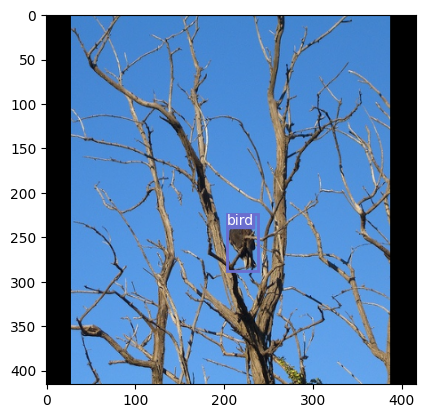

In [17]:
# Creating a dataloader object 
loader = torch.utils.data.DataLoader( 
    dataset=dataset, 
    batch_size=16, 
    shuffle=True, 
) 
  
# Defining the grid size and the scaled anchors 
GRID_SIZE = [13, 26, 52] 
scaled_anchors = torch.tensor(ANCHORS) / ( 
    1 / torch.tensor(GRID_SIZE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
) 
  
# Getting a batch from the dataloader 
x, y = next(iter(loader)) 
  
# Getting the boxes coordinates from the labels 
# and converting them into bounding boxes without scaling 
boxes = [] 
for i in range(y[0].shape[1]): 
    anchor = scaled_anchors[i] 
    boxes += convert_cells_to_bboxes( 
               y[i], is_predictions=False, s=y[i].shape[2], anchors=anchor 
             )[0] 
  
# Applying non-maximum suppression 
boxes = nms(boxes, iou_threshold=1, threshold=0.7) 
print(boxes[0])
# Plotting the image with the bounding boxes 
plot_image(x[0].permute(1,2,0).to("cpu"), boxes,class_labels)

In [11]:
class CNNBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, use_batch_norm=True, **kwargs): 
        super().__init__() 
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not use_batch_norm, **kwargs) 
        self.bn = nn.BatchNorm2d(out_channels) 
        self.activation = nn.LeakyReLU(0.1) 
        self.use_batch_norm = use_batch_norm 
  
    def forward(self, x): 
        # Applying convolution 
        x = self.conv(x) 
        # Applying BatchNorm and activation if needed 
        if self.use_batch_norm: 
            x = self.bn(x) 
            return self.activation(x) 
        else: 
            return x

In [12]:
class ResidualBlock(nn.Module): 
    def __init__(self, channels, use_residual=True, num_repeats=1): 
        super().__init__() 
          
        # Defining all the layers in a list and adding them based on number of  
        # repeats mentioned in the design 
        res_layers = [] 
        for _ in range(num_repeats): 
            res_layers += [ 
                nn.Sequential( 
                    nn.Conv2d(channels, channels // 2, kernel_size=1), 
                    nn.BatchNorm2d(channels // 2), 
                    nn.LeakyReLU(0.1), 
                    nn.Conv2d(channels // 2, channels, kernel_size=3, padding=1), 
                    nn.BatchNorm2d(channels), 
                    nn.LeakyReLU(0.1) 
                ) 
            ] 
        self.layers = nn.ModuleList(res_layers) 
        self.use_residual = use_residual 
        self.num_repeats = num_repeats 
      
    # Defining forward pass 
    def forward(self, x): 
        for layer in self.layers: 
            residual = x 
            x = layer(x) 
            if self.use_residual: 
                x = x + residual 
        return x

In [13]:
class ScalePrediction(nn.Module): 
    def __init__(self, in_channels, num_classes): 
        super().__init__() 
        # Defining the layers in the network 
        self.pred = nn.Sequential( 
            nn.Conv2d(in_channels, 2*in_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(2*in_channels), 
            nn.LeakyReLU(0.1), 
            nn.Conv2d(2*in_channels, (num_classes + 5) * 3, kernel_size=1), 
        ) 
        self.num_classes = num_classes 
      
    # Defining the forward pass and reshaping the output to the desired output  
    # format: (batch_size, 3, grid_size, grid_size, num_classes + 5) 
    def forward(self, x): 
        output = self.pred(x) 
        output = output.view(x.size(0), 3, self.num_classes + 5, x.size(2), x.size(3)) 
        output = output.permute(0, 1, 3, 4, 2) 
        return output

In [14]:
class YOLOv3(nn.Module): 
    def __init__(self, in_channels=3, num_classes=23): 
        super().__init__() 
        self.num_classes = num_classes 
        self.in_channels = in_channels 
  
        # Layers list for YOLOv3 
        self.layers = nn.ModuleList([ 
            CNNBlock(in_channels, 32, kernel_size=3, stride=1, padding=1), 
            CNNBlock(32, 64, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(64, num_repeats=1), 
            CNNBlock(64, 128, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(128, num_repeats=2), 
            CNNBlock(128, 256, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(256, num_repeats=8), 
            CNNBlock(256, 512, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(512, num_repeats=8), 
            CNNBlock(512, 1024, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(1024, num_repeats=4), 
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0), 
            CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(1024, use_residual=False, num_repeats=1), 
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(512, num_classes=num_classes), 
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0), 
            nn.Upsample(scale_factor=2), 
            CNNBlock(768, 256, kernel_size=1, stride=1, padding=0), 
            CNNBlock(256, 512, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(512, use_residual=False, num_repeats=1), 
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(256, num_classes=num_classes), 
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0), 
            nn.Upsample(scale_factor=2), 
            CNNBlock(384, 128, kernel_size=1, stride=1, padding=0), 
            CNNBlock(128, 256, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(256, use_residual=False, num_repeats=1), 
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(128, num_classes=num_classes) 
        ]) 
      
    # Forward pass for YOLOv3 with route connections and scale predictions 
    def forward(self, x): 
        outputs = [] 
        route_connections = [] 
  
        for layer in self.layers: 
            if isinstance(layer, ScalePrediction): 
                outputs.append(layer(x)) 
                continue
            x = layer(x) 
  
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8: 
                route_connections.append(x) 
              
            elif isinstance(layer, nn.Upsample): 
                x = torch.cat([x, route_connections[-1]], dim=1) 
                route_connections.pop() 
        return outputs

In [15]:
if __name__ == "__main__": 
    # Setting number of classes and image size 
    num_classes = 23
    IMAGE_SIZE = 416
  
    # Creating model and testing output shapes 
    model = YOLOv3(num_classes=num_classes) 
    x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE)) 
    out = model(x) 
    print(out[0].shape) 
    print(out[1].shape) 
    print(out[2].shape) 
  
    # Asserting output shapes 
    assert model(x)[0].shape == (1, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5) 
    assert model(x)[1].shape == (1, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5) 
    assert model(x)[2].shape == (1, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5) 
    print("Output shapes are correct!")

torch.Size([1, 3, 13, 13, 28])
torch.Size([1, 3, 26, 26, 28])
torch.Size([1, 3, 52, 52, 28])
Output shapes are correct!


In [16]:
class YOLOLoss(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.mse = nn.MSELoss() 
        self.bce = nn.BCEWithLogitsLoss() 
        self.cross_entropy = nn.CrossEntropyLoss() 
        self.sigmoid = nn.Sigmoid() 
      
    def forward(self, pred, target, anchors): 
        # Identifying which cells in target have objects  
        # and which have no objects 
        obj = target[..., 0] == 1
        no_obj = target[..., 0] == 0
  
        # Calculating No object loss 
        no_object_loss = self.bce( 
            (pred[..., 0:1][no_obj]), (target[..., 0:1][no_obj]), 
        ) 
  
          
        # Reshaping anchors to match predictions 
        anchors = anchors.reshape(1, 3, 1, 1, 2) 
        # Box prediction confidence 
        box_preds = torch.cat([self.sigmoid(pred[..., 1:3]), 
                               torch.exp(pred[..., 3:5]) * anchors 
                            ],dim=-1) 
        # Calculating intersection over union for prediction and target 
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach() 
        # Calculating Object loss 
        object_loss = self.mse(self.sigmoid(pred[..., 0:1][obj]), 
                               ious * target[..., 0:1][obj]) 
  
          
        # Predicted box coordinates 
        pred[..., 1:3] = self.sigmoid(pred[..., 1:3]) 
        # Target box coordinates 
        target[..., 3:5] = torch.log(1e-6 + target[..., 3:5] / anchors) 
        # Calculating box coordinate loss 
        box_loss = self.mse(pred[..., 1:5][obj], 
                            target[..., 1:5][obj]) 
  
          
        # Claculating class loss 
        class_loss = self.cross_entropy((pred[..., 5:][obj]), 
                                   target[..., 5][obj].long()) 
  
        # Total loss 
        return ( 
            box_loss 
            + object_loss 
            + no_object_loss 
            + class_loss 
        )

In [17]:
def training_loop(loader, model, optimizer, loss_fn, scaler, scaled_anchors): 
    # Creating a progress bar 
    progress_bar = tqdm(loader, leave=True) 
  
    # Initializing a list to store the losses 
    losses = [] 
  
    # Iterating over the training data 
    for _, (x, y) in enumerate(progress_bar): 
        x = x.to(device) 
        y0, y1, y2 = ( 
            y[0].to(device), 
            y[1].to(device), 
            y[2].to(device), 
        ) 
  
        with torch.cuda.amp.autocast(): 
            # Getting the model predictions 
            outputs = model(x)
            #print(outputs)
            # Calculating the loss at each scale 
            loss = ( 
                  loss_fn(outputs[0], y0, scaled_anchors[0]) 
                + loss_fn(outputs[1], y1, scaled_anchors[1]) 
                + loss_fn(outputs[2], y2, scaled_anchors[2]) 
            ) 
  
        # Add the loss to the list 
        losses.append(loss.item()) 
  
        # Reset gradients 
        optimizer.zero_grad() 
  
        # Backpropagate the loss 
        scaler.scale(loss).backward() 
  
        # Optimization step 
        scaler.step(optimizer) 
  
        # Update the scaler for next iteration 
        scaler.update() 
  
        # update progress bar with loss 
        mean_loss = sum(losses) / len(losses) 
        progress_bar.set_postfix(loss=mean_loss)
    return losses,mean_loss

In [17]:
import gc
gc.collect()

0

In [ ]:
import torch.optim as optim
import numpy as np
import os



model = YOLOv3().to(device)

# Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=leanring_rate)

# Defining the loss function
loss_fn = YOLOLoss()

# Defining the scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Attempt to load checkpoints
checkpoint_path = "best_checkpoint_epoch.pth.tar"
if os.path.isfile(checkpoint_path):
    try:
        load_checkpoint(checkpoint_path, model, optimizer, leanring_rate)
        print(f"Checkpoint loaded from '{checkpoint_path}'.")
    except Exception as e:
        print(f"Error happened while loading the checkpoint: {e}")
        pass
        #print(f"Error happened while loading the checkpoint: {e}")
else:
    print("Checkpoint does not exist. Starting from scratch.")


# Creating a dataset object 
 
train_dataset = ObjectDetectionDataset( 
    csv_file="/kaggle/working/modified/filtered_dataset.csv", 
    image_dir="/kaggle/working/modified/images", 
    label_dir="/kaggle/working/modified/labels", 
    grid_sizes=[13, 26, 52], 
    anchors=ANCHORS,
    transform=train_transform ,
) 



# Defining the train data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True,
    pin_memory=True,
)

# Scaling the anchors
scaled_anchors = (
    torch.tensor(ANCHORS) *
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(device)

mean_losses = []
losses_list = []
best_loss = float('inf')

# Training the model
for e in range(1, epochs + 1):
    print(f"Epoch: {e}")
    losses, mean_loss = training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
    losses_list.append(np.array(losses))  # Convert to numpy array if it's not already
    mean_losses.append(mean_loss)
    # Save losses
    np.save("/kaggle/working/losses.npy", np.array(losses_list))
    np.save("/kaggle/working/mean_losses.npy", np.array(mean_losses))

    # Saving the model if it's the best so far
    if mean_loss < best_loss:
        best_loss = mean_loss
        print(f"New best loss {best_loss} at epoch {e}, saving model and losses...")
        if save_model:
            checkpoint_filename = f"best_checkpoint_epoch.pth.tar"
            save_checkpoint(model, optimizer, filename=checkpoint_filename)
            


==> Loading checkpoint
Checkpoint loaded from 'best_checkpoint_epoch.pth.tar'.
Epoch: 1


100%|██████████| 465/465 [05:09<00:00,  1.50it/s, loss=0.398]


New best loss 0.3978203619039187 at epoch 1, saving model and losses...
==> Saving checkpoint
Epoch: 2


100%|██████████| 465/465 [05:07<00:00,  1.51it/s, loss=0.421]


Epoch: 3


100%|██████████| 465/465 [05:06<00:00,  1.52it/s, loss=0.362]


New best loss 0.3618137119277831 at epoch 3, saving model and losses...
==> Saving checkpoint
Epoch: 4


 95%|█████████▌| 444/465 [04:53<00:13,  1.52it/s, loss=0.347]

In [ ]:
import matplotlib.pyplot as plt

def plot_batch_losses_with_mean(losses_list, mean_losses):
    """
    Plots all batch losses with mean loss per epoch overlay.

    Parameters:
    - losses_list: A list of lists, where the inner list contains all batch losses concatenated across epochs.
    - mean_losses: A list of mean losses per epoch.
    """
    # Assuming losses_list contains only one list with all batch losses
    all_batch_losses = losses_list[0]
    
    # Calculate the positions to plot mean losses. Assume equal number of batches in each epoch.
    num_batches_per_epoch = len(all_batch_losses) // len(mean_losses)
    mean_loss_positions = [i * num_batches_per_epoch - 0.5 * num_batches_per_epoch for i in range(1, len(mean_losses) + 1)]
    
    plt.figure(figsize=(12, 6))
    
    # Plot all batch losses
    plt.plot(all_batch_losses, label='Batch Loss', color='orange', linewidth=1)
    
    # Overlay mean losses
    plt.scatter(mean_loss_positions, mean_losses, color='red', zorder=5, label='Mean Loss per Epoch')
    plt.plot(mean_loss_positions, mean_losses, color='red', linewidth=2, linestyle='--')
    
    plt.title('Batch Losses Over All Epochs with Mean Loss Overlay')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Set x-ticks to be the epoch numbers at the positions of the mean losses
    plt.xticks(mean_loss_positions, range(1, len(mean_losses) + 1))
    plt.savefig("plot21.png")
    plt.show()
    

In [ ]:
plot_batch_losses_with_mean(losses_list, mean_losses)

## Losses:
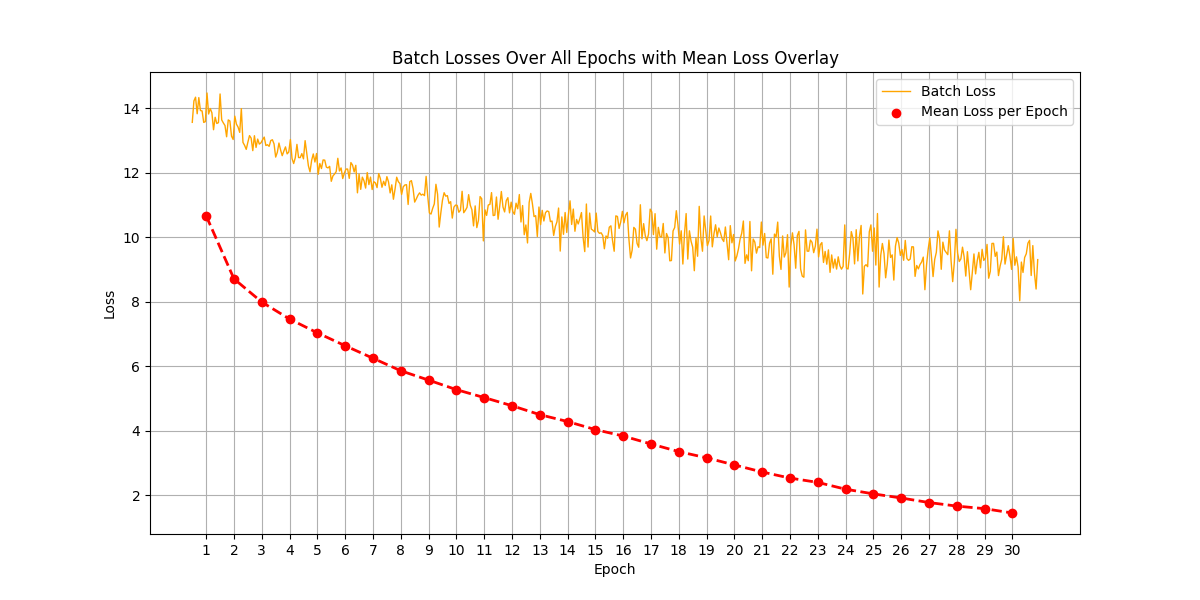

In [34]:
# Assuming YOLOv3, YOLOLoss, save_checkpoint, and load_checkpoint are defined elsewhere
model = YOLOv3().to(device)

# Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=leanring_rate)

# Defining the loss function
loss_fn = YOLOLoss()

# Defining the scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

c:\Users\robot\anaconda3\envs\IDLS24\Lib\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [17]:
class_labels = [ 
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", 
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "face",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor","License_Plate", "motorcyle", "truck"
]

In [20]:
print(len(class_labels))

23


In [18]:
import cv2
import numpy as np
from torchvision import transforms
import torch
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def preprocess_frame(frame, transform):
    """Preprocesses the frame by applying the transformations and moving the tensor to the device."""
    # Apply the transformations
    transformed = transform(image=frame, bboxes=[])
    frame_tensor = transformed["image"].unsqueeze(0).to(device)
    return frame_tensor


In [24]:
# # Attempt to load checkpoints
# checkpoint_path = "best_checkpoint_epoch.pth.tar"
# if os.path.isfile(checkpoint_path):
#     try:
#         load_checkpoint(checkpoint_path, model, optimizer, leanring_rate)
#         print(f"Checkpoint loaded from '{checkpoint_path}'.")
#     except Exception as e:
#         print(f"Error happened while loading the checkpoint: {e}")
# else:
#     print("Checkpoint does not exist. Starting from scratch.")

In [19]:
def get_class_probs(out):
    class_probs = []
    for tensor in out:
        class_probs.append(torch.nn.functional.softmax(tensor[..., 5:], dim=-1))
    return class_probs

In [20]:
# Save the class_probs_dict to a file
import json
def save_class_probs_dict(class_probs_dict_list, filename):

    # create new key of class name and value of class probabilities 
   
    # if the file exists, load the existing class_probs_dict
    if os.path.exists(filename):
        with open(filename) as f:
            existing_class_probs_dict = json.load(f)
        # update the existing list with the new class_probs_dict list
        for class_probs_dict in class_probs_dict_list:
            existing_class_probs_dict.append(class_probs_dict)
    # Save the class_probs_dict to a file
    with open(filename, "w") as f:
        json.dump(existing_class_probs_dict, f)


In [21]:
def get_class_probs_dict(class_probs, boxes, iou_threshold, threshold):
    class_probs_dict_list = []
  
    # Apply non-maximum suppression to the bounding boxes
    bboxes_nms = nms(boxes, iou_threshold, threshold)
    print(len(class_probs))
    print(len(boxes))
    for tensor in class_probs:
        # Reshape the tensor to combine the batch size, anchor box, and grid size dimensions
        tensor = tensor.reshape(-1, tensor.shape[-1])
        # Convert the tensor to a list
        class_probs_list = tensor.tolist()
        
        for i, probs in enumerate(class_probs_list):
            # Check if the bounding box is in the list of boxes after non-maximum suppression
            if boxes[i] in bboxes_nms:
                # check the length of the class_probs and boxes
                # print("Length of class_probs and boxes are equal")
                # print(len(probs))
                # print("Length of class_labels")
                # print(len(class_labels))
                # print(class_labels)
                
                # Create a dictionary with the class indices as keys
                class_probs_dict = {class_labels[i]: prob for i, prob in enumerate(probs)}
                #class_probs_dict.update({"class": class_labels[i]})
                class_probs_dict_list.append(class_probs_dict)
               
    return class_probs_dict_list

In [37]:
def predict_faces(frame, model, device, ANCHORS, convert_cells_to_bboxes, nms):
    """Predicts faces in the frame using the model and applies non-maximum suppression."""
    GRID_SIZE = [13, 26, 52]
    scaled_anchors = (torch.tensor(ANCHORS) / (1 / torch.tensor(GRID_SIZE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))).to(device)
    
    x = preprocess_frame(frame, test_transform)
   
    with torch.no_grad():
        predictions = model(x)
    
   
    all_boxies = []
    for i in range(predictions[0].shape[1]):
        anchor = scaled_anchors[i]
        prediction = predictions[i]
        boxies = convert_cells_to_bboxes(prediction, is_predictions=True, s=prediction.shape[2], anchors=anchor)
        all_boxies += boxies[0]
        #class_probs.append(scores[0])

    boxes = nms(all_boxies, iou_threshold=1, threshold=0.8)
    class_probs = get_class_probs(predictions)
    class_prob_dict = get_class_probs_dict(class_probs,all_boxies,1,0.8)
   
    return boxes,class_prob_dict

In [27]:
# Create a video from images in the directory

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from PIL import Image
import json
import cv2
import os

images_dir = "./images"
video_filename = "video.avi"
images_dir = "./images"
video_filename = "video.avi"

# Get the list of image filenames in the directory
image_filenames = sorted(os.listdir(images_dir))

# Read the first image to get the image size
first_image = cv2.imread(os.path.join(images_dir, image_filenames[0]))
height, width, _ = first_image.shape

# Create a VideoWriter object to write the video
fourcc = cv2.VideoWriter_fourcc(*"XVID")
video_writer = cv2.VideoWriter(video_filename, fourcc, 1.0, (width, height))

# Iterate over the image filenames and write each frame to the video
for image_filename in image_filenames:
    image_path = os.path.join(images_dir, image_filename)
    frame = cv2.imread(image_path)
    video_writer.write(frame)

# Release the VideoWriter object
video_writer.release()

print(f"Video sequence created: {video_filename}")



Video sequence created: video.avi


In [33]:
def detect_faces(cap, model, device, ANCHORS, convert_cells_to_bboxes, nms, plot_image, class_labels):
    """Detects faces in the video stream from the webcam."""
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output1.avi', fourcc, 1.0, (640, 480))
    while True:
        # Read a frame from the webcam
        ret, frame = cap.read()

        # If the frame was not read successfully, break from the loop
        if not ret:
            print("Failed to read frame from webcam. Exiting...")
            break

        # Convert the frame to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Predict faces in the frame
        boxes,class_probs = predict_faces(frame, model, device, ANCHORS, convert_cells_to_bboxes, nms)
        save_class_probs_dict(class_probs, "class_probs.json")
        # Plot the frame with the detected faces
        # Get the annotated frame
        annotated_frame = plot_image(frame, boxes, class_labels)

        # Convert the annotated frame from RGB to BGR (because OpenCV uses BGR)
        annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)

        # Write the annotated frame to the video file
        out.write(annotated_frame)
      

        # Display the frame
        clear_output(wait=True)
        display(Image.fromarray(annotated_frame))
        time.sleep(5.0)  # Increase the sleep time to slow down the video playback
        
    # Release the webcam when done
    cap.release()
    # Release the VideoWriter when done
    out.release()
    #cv2.destroyAllWindows()


In [25]:
import time
def detect_plates(cap, model, device, ANCHORS, convert_cells_to_bboxes, nms, plot_image, class_labels):
    """Detects faces in the video stream from the webcam."""
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_plates.avi', fourcc, 1.0, (640, 480))
    while True:
        # Read a frame from the webcam
        ret, frame = cap.read()

        # If the frame was not read successfully, break from the loop
        if not ret:
            print("Failed to read frame from webcam. Exiting...")
            break

        # Convert the frame to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Predict faces in the frame
        boxes,class_probs = predict_faces(frame, model, device, ANCHORS, convert_cells_to_bboxes, nms)
        save_class_probs_dict(class_probs, "class_probs.json")
        # Plot the frame with the detected faces
        # Get the annotated frame
        annotated_frame = plot_image(frame, boxes, class_labels)

        # Convert the annotated frame from RGB to BGR (because OpenCV uses BGR)
        annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)

        # Write the annotated frame to the video file
        out.write(annotated_frame)
      

        # Display the frame
        clear_output(wait=True)
        display(Image.fromarray(annotated_frame))
        time.sleep(0.9)
        

    # Release the webcam when done
    cap.release()
    # Release the VideoWriter when done
    #cv2.destroyAllWindows()
    

In [49]:
cap.release()

In [35]:
# Attempt to load checkpoints
checkpoint_path = "best_checkpoint_epoch.pth (3).tar"
if os.path.isfile(checkpoint_path):
    try:
        load_checkpoint(checkpoint_path, model, optimizer, leanring_rate)
        print(f"Checkpoint loaded from '{checkpoint_path}'.")
    except Exception as e:
        print(f"Error happened while loading the checkpoint: {e}")
else:
    print("Checkpoint does not exist. Starting from scratch.")

==> Loading checkpoint
Checkpoint loaded from 'best_checkpoint_epoch.pth (3).tar'.


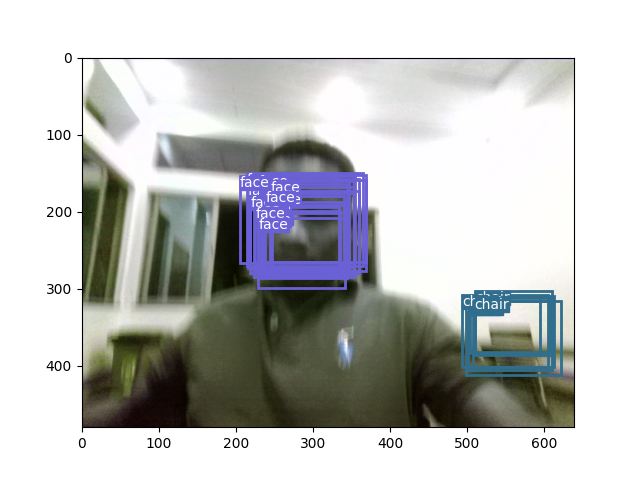

KeyboardInterrupt: 

In [51]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(0)
model.eval()
args = {
    'cap': cap,
    'model': model,
    'device': device,
    'ANCHORS': ANCHORS,
    'convert_cells_to_bboxes': convert_cells_to_bboxes,
    'nms': nms,
    'plot_image': plot_image,
    'class_labels': class_labels
}

detect_faces(**args)


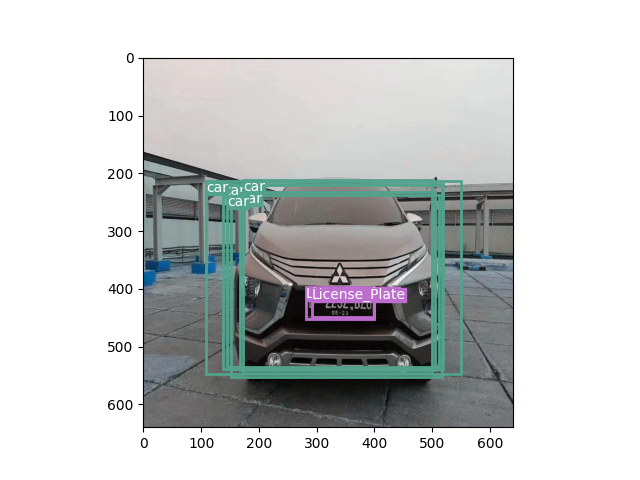

Failed to read frame from webcam. Exiting...


In [39]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Create a VideoCapture object
cap = cv2.VideoCapture(video_filename)
model.eval()
args = {
    'cap': cap,
    'model': model,
    'device': device,
    'ANCHORS': ANCHORS,
    'convert_cells_to_bboxes': convert_cells_to_bboxes,
    'nms': nms,
    'plot_image': plot_image,
    'class_labels': class_labels
}

detect_plates(**args)
